## Importing the required libraries

In [1]:
!pip install numpy==1.23.0

  Using cached numpy-1.23.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.2 kB)
Using cached numpy-1.23.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.0 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xgboost 2.1.1 requires nvidia-nccl-cu12; platform_system == "Linux" and platform_machine != "aarch64", which is not installed.
albucore 0.0.13 requires numpy<2,>=1.24.4, but you have numpy 1.23.0 which is incompatible.
albumentations 1.4.13 requires numpy>=1.24.4, but you have numpy 1.23.0 which is incompatible.
chex 0.1.86 requires numpy>=1.24.1, but you have numpy 1.23.0 which is incompatible.
pandas-stubs 2.1.4.231227 requires numpy>=1.26.0; python_version < "3.13", 

In [2]:
!pip install librosa  matplotlib tensorflow keras scikit-learn

  Using cached numpy-1.26.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.2 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.0
    Uninstalling numpy-1.23.0:
      Successfully uninstalled numpy-1.23.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xgboost 2.1.1 requires nvidia-nccl-cu12; platform_system == "Linux" and platform_machine != "aarch64", which is not installed.


In [3]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix

In [4]:
from keras import regularizers

In [5]:
import os

In [6]:
from google.colab import drive
import zipfile
import wave
import shutil


drive.mount('/content/drive')
zip_file_path = '/content/drive/My Drive/Audio_Speech_Actors_01-24.zip'
# extract_folder_path = '/content/drive/My Drive/Audio_Speech_Actors_01-24'
rawdata_folder = '/content/drive/My Drive/Rawdata'

# os.makedirs(rawdata_folder, exist_ok=True)
# if not os.path.isdir(extract_folder_path):
#   with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_folder_path)

# # Iterate through actor folders and move .wav files to Rawdata
# for actor_folder in os.listdir(extract_folder_path):
#   actor_folder_path = os.path.join(extract_folder_path, actor_folder)

#   if os.path.isdir(actor_folder_path):
#     print(f'Processing actor: {actor_folder}')
#     for filename in os.listdir(actor_folder_path):
#       if filename.endswith('.wav'):
#         wav_file_path = os.path.join(actor_folder_path, filename)
#         print(f'  Moving {wav_file_path} to Rawdata')
#         shutil.move(wav_file_path, rawdata_folder)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
mylist= os.listdir(rawdata_folder)

In [8]:
print(len(mylist))

1440


## Plotting the audio file's waveform and its spectrogram

In [9]:
audio_file_path = '/content/drive/My Drive/Rawdata/03-01-07-02-01-02-06.wav'


In [10]:
from IPython.display import Audio, display

sr = 23000

# Display the audio
display(Audio(filename=audio_file_path, rate=sr))

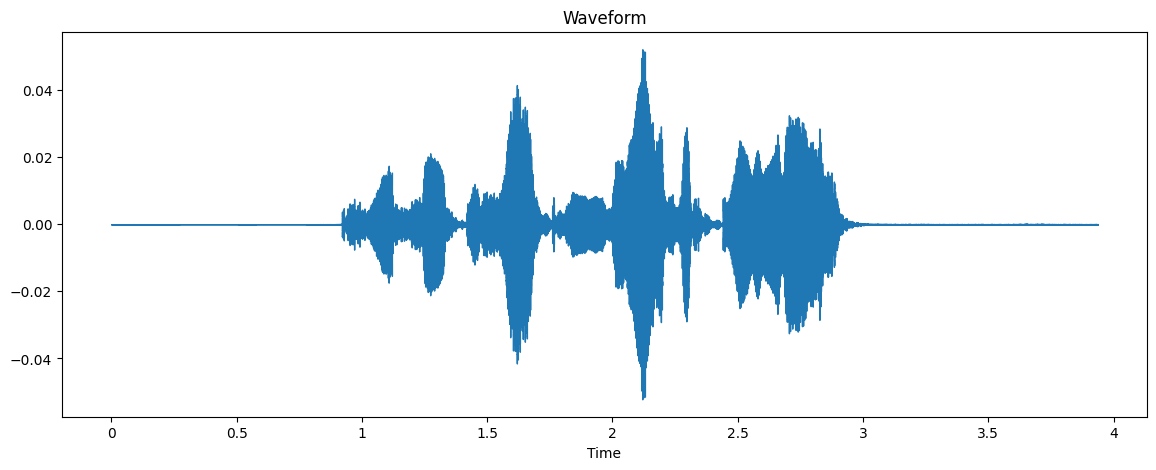

In [11]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

y, sr = librosa.load(audio_file_path, sr=sr)

plt.figure(figsize=(14, 5))
librosa.display.waveshow(y, sr=sr)
plt.title('Waveform')
plt.show()

<ipython-input-12-870fca7220c7>:7: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sr,x = scipy.io.wavfile.read('/content/drive/My Drive/Rawdata/03-01-05-02-01-02-06.wav')


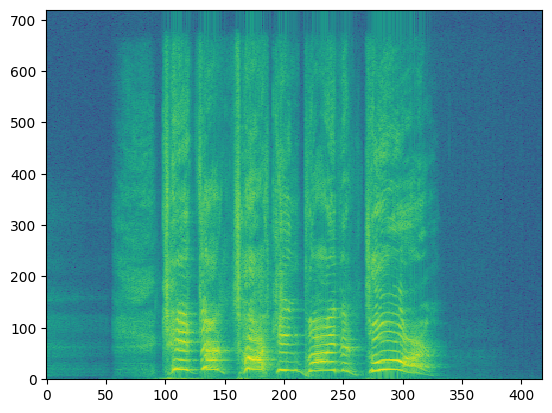

In [12]:
import matplotlib.pyplot as plt
import scipy.io.wavfile
import numpy as np
import sys


sr,x = scipy.io.wavfile.read('/content/drive/My Drive/Rawdata/03-01-05-02-01-02-06.wav')

## Parameters: 10ms step, 30ms window
nstep = int(sr * 0.01)
nwin  = int(sr * 0.03)
nfft = nwin

window = np.hamming(nwin)

## will take windows x[n1:n2].  generate
## and loop over n2 such that all frames
## fit within the waveform
nn = range(nwin, len(x), nstep)

X = np.zeros( (len(nn), nfft//2) )

for i,n in enumerate(nn):
    xseg = x[n-nwin:n]
    z = np.fft.fft(window * xseg, nfft)
    X[i,:] = np.log(np.abs(z[:nfft//2]))

plt.imshow(X.T, interpolation='nearest',
    origin='lower',
    aspect='auto')

plt.show()

## Setting the labels

In [ ]:
feeling_list=[]
# Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
# Repetition (01 = 1st repetition, 02 = 2nd repetition).
# Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).
for item in mylist:
    # print(item)

    if item[6:-16]=='02' and int(item[18:-4])%2==0:
        feeling_list.append('female_calm')
    elif item[6:-16]=='02' and int(item[18:-4])%2==1:
        feeling_list.append('male_calm')
    elif item[6:-16]=='03' and int(item[18:-4])%2==0:
        feeling_list.append('female_happy')
    elif item[6:-16]=='03' and int(item[18:-4])%2==1:
        feeling_list.append('male_happy')
    elif item[6:-16]=='04' and int(item[18:-4])%2==0:
        feeling_list.append('female_sad')
    elif item[6:-16]=='04' and int(item[18:-4])%2==1:
        feeling_list.append('male_sad')
    elif item[6:-16]=='05' and int(item[18:-4])%2==0:
        feeling_list.append('female_angry')
    elif item[6:-16]=='05' and int(item[18:-4])%2==1:
        feeling_list.append('male_angry')
    elif item[6:-16]=='06' and int(item[18:-4])%2==0:
        feeling_list.append('female_fearful')
    elif item[6:-16]=='06' and int(item[18:-4])%2==1:
        feeling_list.append('male_fearful')

In [ ]:
import pandas as pd
labels = pd.DataFrame(feeling_list)

In [ ]:
labels[10:20]

## Getting the features of audio files using librosa

In [13]:

# !pip install --force-reinstall resampy
!pip install resampy


In [14]:
import os
import numpy as np
import librosa

def extract_mfcc(file_path, sr=22050, n_mfcc=40):
    y, sr = librosa.load(file_path, sr=sr, res_type='kaiser_fast')
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    mfccs = np.mean(mfccs.T, axis=0)
    return mfccs

# Replace with the path to your dataset
dataset_path = rawdata_folder

mfcc_features = []

for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file.endswith('.wav'):
            try:
                file_path = os.path.join(root, file)
                mfccs = extract_mfcc(file_path)
                file_class = int(file[7:8]) - 1  # Extracting class from the file name
                mfcc_features.append((mfccs, file_class))
            except ValueError as err:
                print(f"Error processing file {file}: {err}")

# Check if the extraction worked
print(f"Extracted {len(mfcc_features)} files")
for i in range(5):  # Print the first 5 entries
    print(mfcc_features[i])


Extracted 1440 files
(array([-7.27533325e+02,  6.64902573e+01,  1.14867907e+01,  2.37705021e+01,
        9.51487064e+00,  1.10988703e+01, -4.60195690e-01, -5.12963580e-03,
       -4.21305370e+00,  2.78547478e+00, -2.78750372e+00, -3.68180966e+00,
       -5.39819241e-01,  3.16176653e+00, -1.08463347e+00,  1.86655021e+00,
       -3.49962330e+00,  5.88247156e+00,  1.06802195e-01,  5.85150337e+00,
        4.37308341e-01,  2.25292253e+00, -1.01409984e+00,  4.94017124e+00,
        9.42660570e-01,  3.45146155e+00, -2.77807564e-01,  4.35055542e+00,
        2.47904897e+00,  7.09356499e+00,  4.96210527e+00,  8.21215057e+00,
        9.17725658e+00,  8.38973999e+00,  7.23515320e+00,  4.34000635e+00,
        2.38348365e+00,  1.94723582e+00,  2.20792127e+00,  3.06408882e+00],
      dtype=float32), 3)
(array([-7.3622083e+02,  7.5349449e+01,  7.7532620e+00,  2.7880842e+01,
        4.0918741e+00,  8.5355091e+00,  1.2134762e+00, -3.3916381e-01,
       -2.1362228e+00,  8.7565094e-01, -2.5624595e+00,  4.6

In [16]:
import joblib

# Unzipping the list and converting to NumPy arrays
X, y = zip(*mfcc_features)
X, y = np.asarray(X), np.asarray(y)
print(X.shape, y.shape)

# Define the directory path to save the arrays
SAVE_DIR_PATH = '/content/drive/My Drive/MFCC_1'  # Replace with your directory path

# Check if the directory exists, if not, create it
if not os.path.isdir(SAVE_DIR_PATH):
    os.makedirs(SAVE_DIR_PATH)

# Save the arrays to files using joblib
joblib.dump(X, os.path.join(SAVE_DIR_PATH, 'X.joblib'))
joblib.dump(y, os.path.join(SAVE_DIR_PATH, 'y.joblib'))


(1440, 40) (1440,)


['/content/drive/My Drive/MFCC_1/y.joblib']

In [15]:


# df = pd.DataFrame(columns=['feature'])
# bookmark=0
# for index,y in enumerate(mylist):
#     if mylist[index][6:-16]!='01' and mylist[index][6:-16]!='07' and mylist[index][6:-16]!='08' and mylist[index][:2]!='su' and mylist[index][:1]!='n' and mylist[index][:1]!='d':
#         X, sample_rate = librosa.load(rawdata_folder+'/'+y, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
#         sample_rate = np.array(sample_rate)
#         mfccs = np.mean(librosa.feature.mfcc(y=X,
#                                             sr=sample_rate,
#                                             n_mfcc=13),
#                         axis=0)
#         feature = mfccs
#         #[float(i) for i in feature]
#         #feature1=feature[:135]
#         df.loc[bookmark] = [feature]
#         bookmark=bookmark+1

NameError: name 'pd' is not defined

In [ ]:
# df3 = pd.DataFrame(df['feature'].values.tolist())

df3[:5]

In [ ]:
# newdf = pd.concat([df3,labels], axis=1)

In [ ]:
# rnewdf = newdf.rename(index=str, columns={"0": "label"})

In [17]:
# from sklearn.utils import shuffle
# rnewdf = shuffle(newdf)
# rnewdf[:10]

NameError: name 'newdf' is not defined

In [ ]:
# rnewdf=rnewdf.fillna(0)

## Dividing the data into test and train

In [ ]:
newdf1 = np.random.rand(len(rnewdf)) < 0.8
train = rnewdf[newdf1]
test = rnewdf[~newdf1]

In [ ]:
train[250:260]

In [ ]:
trainfeatures = train.iloc[:, :-1]

In [ ]:
trainlabel = train.iloc[:, -1:]

In [ ]:
testfeatures = test.iloc[:, :-1]

In [ ]:
testlabel = test.iloc[:, -1:]

In [ ]:
from keras.utils import to_categorical  # Import to_categorical directly
from sklearn.preprocessing import LabelEncoder

X_train = np.array(trainfeatures)
y_train = np.array(trainlabel)
X_test = np.array(testfeatures)
y_test = np.array(testlabel)

lb = LabelEncoder()

# Use to_categorical directly instead of np_utils
y_train = to_categorical(lb.fit_transform(y_train))
y_test = to_categorical(lb.fit_transform(y_test))


In [ ]:
y_train

In [ ]:
X_train.shape

## Changing dimension for CNN model

In [18]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Activation
from tensorflow.keras.models import Sequential

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split


In [19]:
model = Sequential()

model.add(Conv1D(64, 5, padding='same', input_shape=(40, 1)))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(8))
model.add(Activation('softmax'))

model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 40, 64)              │             384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 40, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 40, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2560)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 8)                   │          20,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 8)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,872 (81.53 KB)

 Trainable params: 20,872 (81.53 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Expand dimensions for CNN input
X_traincnn = np.expand_dims(X_train, axis=2)
X_testcnn = np.expand_dims(X_test, axis=2)

print(X_traincnn.shape, X_testcnn.shape)


(1008, 40, 1) (432, 40, 1)


In [28]:
y_train = keras.utils.to_categorical(y_train, num_classes=8)  # Replace 8 with the number of your classes
y_test = keras.utils.to_categorical(y_test, num_classes=8)


In [43]:
opt = keras.optimizers.RMSprop(learning_rate=0.00001)

In [30]:
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

### Removed the whole training part for avoiding unnecessary long epochs list

In [31]:
cnnhistory=model.fit(X_traincnn, y_train, batch_size=16, epochs=500, validation_data=(X_testcnn, y_test))

Epoch 1/600
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.1271 - loss: 23.8770 - val_accuracy: 0.1389 - val_loss: 19.1250
Epoch 2/600
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1258 - loss: 21.6462 - val_accuracy: 0.1389 - val_loss: 15.5771
Epoch 3/600
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1387 - loss: 18.4164 - val_accuracy: 0.1343 - val_loss: 12.6814
Epoch 4/600
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1370 - loss: 17.2598 - val_accuracy: 0.1343 - val_loss: 10.4912
Epoch 5/600
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1067 - loss: 15.3039 - val_accuracy: 0.1343 - val_loss: 9.0802
Epoch 6/600
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1337 - loss: 13.5776 - val_accuracy: 0.1412 - val_loss: 7.8670
Epoch 7/600
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1665 - loss: 12.7414 - val_accuracy: 0.1250 - val_loss: 6.9069
Epoch 8/600
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1330 - loss: 12.8477 - val_accuracy

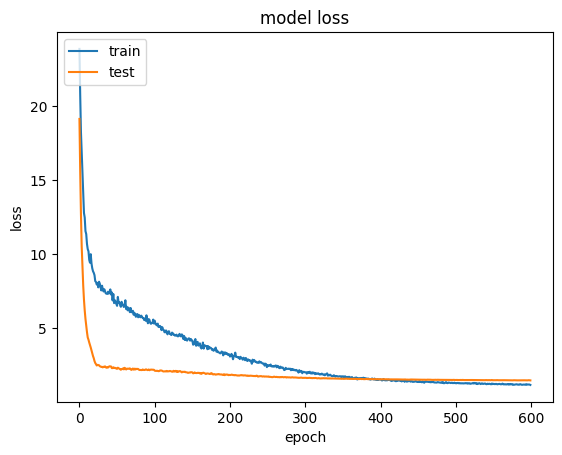

In [32]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

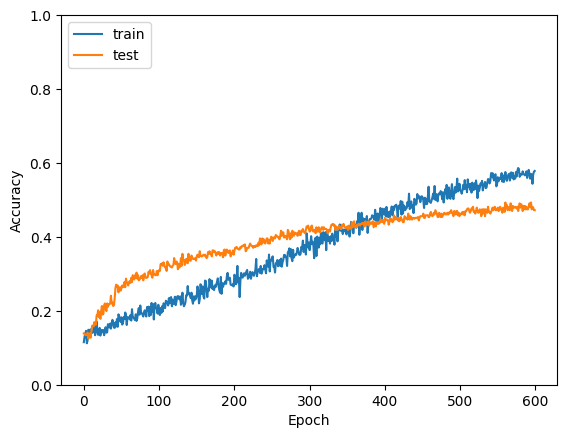

In [33]:
plt.plot(cnnhistory.history['accuracy'], label = 'accuracy')
plt.plot(cnnhistory.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
# plt.legend(loc = 'upper right)
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Saving the model

In [34]:
model_name = 'Emotion_Voice_Detection_Model.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at /content/saved_models/Emotion_Voice_Detection_Model.h5 


In [35]:
import json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

## Loading the model

In [36]:
# loading json and creating model
from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("saved_models/Emotion_Voice_Detection_Model.h5")
print("Loaded model from disk")

# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(X_testcnn, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
compile_metrics: 47.22%


## Predicting emotions on the test data

In [37]:
preds = loaded_model.predict(X_testcnn,
                         batch_size=32,
                         verbose=1)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [38]:
preds

array([[2.0349832e-02, 9.3339258e-01, 1.8832341e-03, ..., 6.9370857e-03,
        9.0294769e-03, 7.3785898e-03],
       [1.4537422e-04, 2.9079405e-05, 2.3274687e-01, ..., 3.2803467e-01,
        2.3212056e-03, 5.8860928e-03],
       [1.0149453e-01, 7.9756522e-01, 1.0317324e-02, ..., 2.0250393e-02,
        1.0974766e-02, 1.1479420e-02],
       ...,
       [4.8378329e-03, 4.7526315e-02, 8.0340408e-02, ..., 2.0489928e-01,
        1.6838297e-01, 3.9436582e-01],
       [1.8488867e-02, 5.3510767e-01, 3.0675374e-02, ..., 1.3200331e-01,
        1.2076359e-01, 1.3714488e-01],
       [2.0325683e-06, 4.3892969e-06, 3.0861622e-02, ..., 2.1285813e-03,
        2.7154025e-03, 7.2947000e-03]], dtype=float32)

In [39]:
preds1=preds.argmax(axis=1)

In [40]:
preds1

array([1, 3, 1, 3, 4, 3, 3, 3, 7, 5, 0, 3, 5, 3, 5, 1, 0, 7, 0, 6, 6, 3,
       1, 5, 7, 1, 1, 2, 1, 7, 5, 7, 5, 7, 3, 3, 1, 0, 3, 0, 3, 1, 4, 0,
       0, 4, 1, 2, 7, 3, 6, 5, 5, 7, 3, 4, 7, 2, 4, 1, 4, 7, 5, 5, 0, 3,
       6, 1, 1, 5, 4, 7, 2, 1, 7, 4, 7, 2, 5, 0, 4, 1, 5, 0, 4, 7, 1, 2,
       4, 3, 3, 3, 6, 1, 7, 1, 7, 4, 4, 0, 1, 1, 2, 7, 5, 5, 4, 1, 5, 1,
       2, 7, 2, 4, 2, 6, 1, 1, 1, 7, 1, 4, 7, 0, 4, 7, 7, 4, 3, 0, 3, 5,
       5, 7, 4, 6, 5, 5, 1, 3, 4, 4, 3, 7, 3, 5, 7, 3, 7, 0, 1, 1, 5, 7,
       1, 3, 4, 5, 5, 7, 2, 7, 7, 5, 4, 1, 7, 3, 5, 4, 2, 5, 5, 6, 2, 6,
       0, 2, 5, 6, 3, 7, 4, 5, 6, 1, 2, 6, 5, 6, 0, 7, 3, 5, 5, 4, 6, 2,
       1, 4, 6, 2, 2, 6, 7, 6, 0, 7, 3, 2, 4, 3, 2, 3, 0, 7, 6, 0, 2, 2,
       1, 7, 3, 7, 5, 3, 7, 4, 5, 5, 5, 7, 4, 0, 7, 5, 6, 1, 7, 1, 1, 3,
       4, 0, 5, 1, 1, 3, 7, 5, 7, 2, 6, 6, 7, 1, 7, 2, 5, 7, 6, 1, 3, 4,
       7, 7, 1, 4, 2, 7, 4, 6, 4, 4, 6, 4, 6, 4, 1, 5, 4, 3, 0, 3, 2, 3,
       4, 5, 6, 3, 1, 7, 3, 7, 1, 3, 6, 2, 7, 5, 6,

In [41]:
abc = preds1.astype(int).flatten()

In [42]:
predictions = (lb.inverse_transform((abc)))

NameError: name 'lb' is not defined

In [ ]:
preddf = pd.DataFrame({'predictedvalues': predictions})
preddf[:10]

In [ ]:
actual=y_test.argmax(axis=1)
abc123 = actual.astype(int).flatten()
actualvalues = (lb.inverse_transform((abc123)))

In [ ]:
actualdf = pd.DataFrame({'actualvalues': actualvalues})
actualdf[:10]

In [ ]:
finaldf = actualdf.join(preddf)

## Actual v/s Predicted emotions

In [ ]:
finaldf[170:180]

In [ ]:
finaldf.groupby('actualvalues').count()

In [ ]:
finaldf.groupby('predictedvalues').count()

In [ ]:
finaldf.to_csv('Predictions.csv', index=False)